In [6]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import sys
import copy
import matplotlib
%matplotlib inline
sys.path.append("..")
from demo_2_awac import och_2_awac
import adept_envs
import gym
env = gym.make("franka_microwave_cabinet_slider_resetfree_newcode-v1")

# all_paths = ['../../../sim_franka/rpl_reset_free/recordings/play_segmented_CS.pkl',]
             
all_paths = ['/usr/local/google/home/abhishekunique/hardware_franka/rpl_reset_free/recordings/recording_3elems.pkl']
dat = []

for p in all_paths:
    dat_curr = pickle.load(open(p, 'rb'))
    dat += dat_curr
print(len(dat))


225


(225, 18)


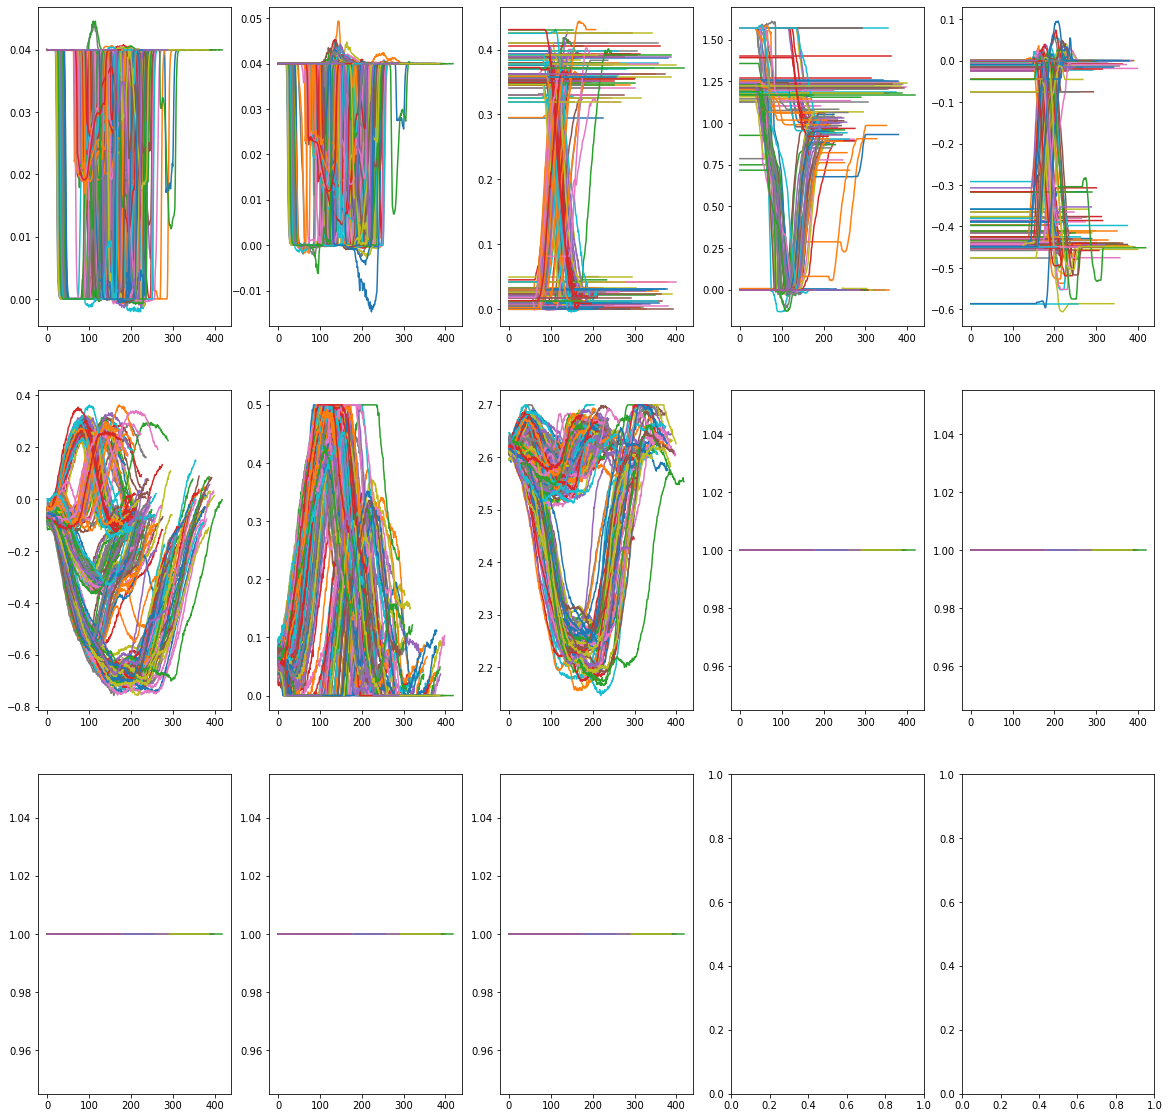

In [7]:
list_awac = och_2_awac(dat)
print(list_awac[0]['observations'].shape)
curr_x = 0
fig, ax = plt.subplots(3, 5, figsize=(20, 20))
for p in list_awac:
    for i in range(3):  
        for j in range(5):
            if i*5 + j == 13:
                break
            if i*5 +j == 1: 
                ax[i][j].plot(range(curr_x, curr_x + len(p['observations'])), p['observations'][:, i*5 + j])
            else:
                ax[i][j].plot(range(curr_x, curr_x + len(p['observations'])), p['observations'][:, i*5 + j])

plt.show()

(225, 18)
(209, 18)
(322, 18)
(313, 18)
(205, 18)
(277, 18)
(212, 18)
(225, 18)
(304, 18)
(215, 18)
(230, 18)
(251, 18)
(209, 18)
(316, 18)
(337, 18)
(228, 18)
(274, 18)
(224, 18)
(299, 18)
(226, 18)
(211, 18)
(351, 18)
(234, 18)
(211, 18)
(234, 18)
(375, 18)
(197, 18)
(215, 18)
(296, 18)
(348, 18)
(215, 18)
(357, 18)
(220, 18)
(276, 18)
(256, 18)
(366, 18)
(302, 18)
(219, 18)
(391, 18)
(162, 18)
(380, 18)
(201, 18)
(349, 18)
(213, 18)
(241, 18)
(202, 18)
(202, 18)
(302, 18)
(217, 18)
(261, 18)
(228, 18)
(378, 18)
(202, 18)
(276, 18)
(389, 18)
(198, 18)
(188, 18)
(246, 18)
(400, 18)
(190, 18)
(231, 18)
(286, 18)
(185, 18)
(227, 18)
(239, 18)
(364, 18)
(180, 18)
(181, 18)
(206, 18)
(293, 18)
(214, 18)
(157, 18)
(165, 18)
(301, 18)
(262, 18)
(243, 18)
(172, 18)
(219, 18)
(183, 18)
(197, 18)
(188, 18)
(290, 18)
(251, 18)
(202, 18)
(173, 18)
(237, 18)
(233, 18)
(356, 18)
(249, 18)
(354, 18)
(188, 18)
(192, 18)
(229, 18)
(229, 18)
(327, 18)
(186, 18)
(152, 18)
(236, 18)
(189, 18)
(281, 18)


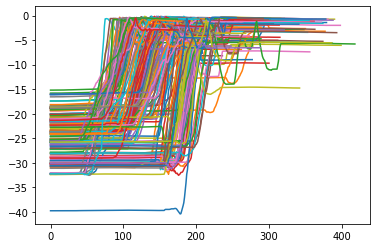

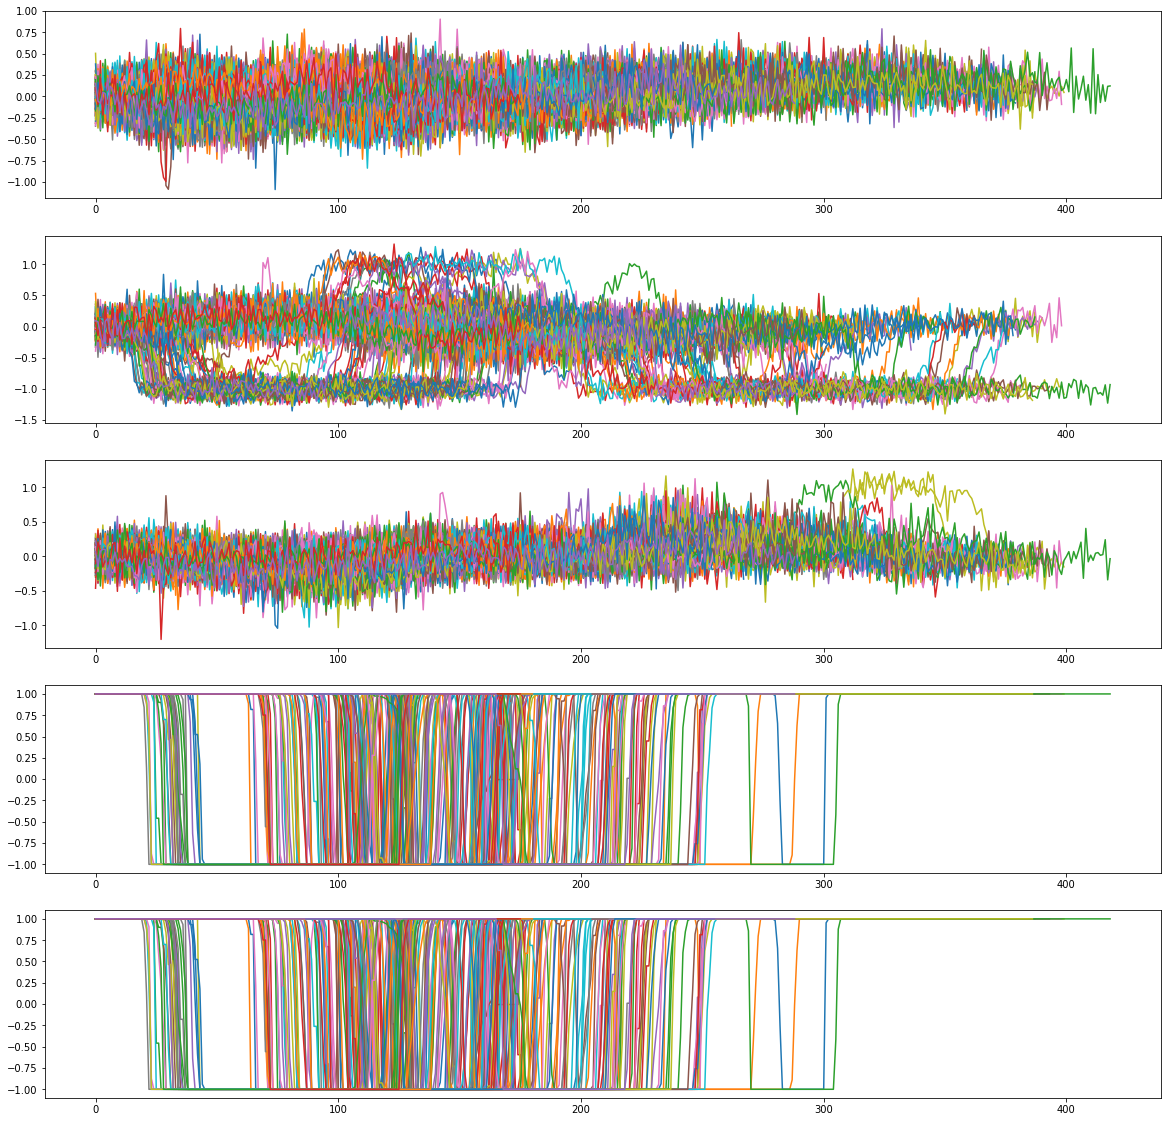

NUMBER OF FILTERED PATHS IS 225


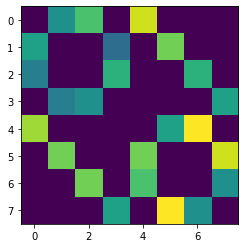

In [10]:
import itertools
def check_goal_completion(curr_pos):
    max_objs = np.array([0.27, 0.7, -0.1])
    min_objs = np.array([0.07, 0.1, -0.275])
    init_bitflips = np.array([0, 0, 0])
    curr_bitflips = init_bitflips.copy()
    broken = False
    for j, pos_idx in enumerate([0, 1, 2]):
        if curr_pos[pos_idx] > max_objs[j]:
            curr_bitflips[j] = 1
        elif curr_pos[pos_idx] < min_objs[j]:
            curr_bitflips[j] = 0
        else:
            print("BROKEN")
            broken = True
    new_idx = 4*curr_bitflips[0] + 2*curr_bitflips[1] + curr_bitflips[2]
    return new_idx, broken

idx_completion = False
def end_relabel(env, path):
    o_size = 8
#     path['observations'][:, o_size:] = path['observations'][-1, :o_size].copy()
#     path['next_observations'][:, o_size:] = path['observations'][-1, :o_size]
    env.env._goal_idx, _ = check_goal_completion(path['observations'][-1, 2:5])
    env.env._current_idx, _ = check_goal_completion(path['observations'][0, 2:5])
    concat_val = np.ones((path['observations'].shape[0], 10))*env.env._goal_idx
    path['observations'] = np.concatenate([path['observations'][:, :o_size], concat_val], axis=-1)
    path['next_observations'] = np.concatenate([path['next_observations'][:, :o_size], concat_val], axis=-1)
    env.env.goal = concat_val #path['observations'][-1, :o_size].copy()
    env.env._idx_completion = idx_completion
    path['rewards'] = np.zeros_like(path['rewards'])
    for idx in range(len(path['observations'])):
        reward_dict = env.env.get_reward_dict(None, {'obj_qp': path['observations'][idx:idx+1, 2:5],
                                                     'mocap_pos': path['observations'][idx:idx+1, 5:8]})
        path['rewards'][idx] = np.sum([v for k, v in reward_dict.items()])
    return path


list_awac = och_2_awac(dat)
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt 
curr_x = 0  
label_list = itertools.product(['SC', 'SO'], ['CC', 'CO'], ['MC', 'MO'],)
tasks = ['-'.join(s) for s in label_list]
# tasks = ['CC', 'CO', 'OC', 'OO']
task_list = []
adjacency_matrix = np.zeros((8, 8))
labeled_goals = [[] for _ in range(8)]
counts_starts = np.zeros(8)
counts_goals = np.zeros(8)
end_states_val = [None for _ in range(8)]
end_states = [None for _ in range(8)]

path_lists = [[[] for _ in range(8)] for _ in range(8)]

filtered_paths = []
for i, path in enumerate(list_awac):
    si, b = check_goal_completion(path['observations'][0, 2:5])
    gi, b2 = check_goal_completion(path['observations'][-1, 2:5])
    if b or b2:
        continue
    end_relabel(env, path)
    print(path['observations'].shape)
    plt.plot(path['rewards'])
    filtered_paths.append(path)
plt.show()
    
for path in filtered_paths:
    mocap_poss = np.concatenate([path['actions'][:, :3], path['actions'][:, -2:]], axis=-1)
    path['actions'] = mocap_poss
fig,  ax = plt.subplots(5, figsize=(20, 20))
for p in filtered_paths:
    for i in range(5):  
        ax[i].plot(p['actions'][:, i])
plt.show()

print("NUMBER OF FILTERED PATHS IS %d"%(len(filtered_paths)))


for p in filtered_paths:
    curr_x += len(p['observations'])
    start_idx, _ = check_goal_completion(p['observations'][0, 2:5])
    start = tasks[start_idx]
    end_idx, _ = check_goal_completion(p['observations'][-1, 2:5])
    end = tasks[end_idx]
    adjacency_matrix[start_idx, end_idx] += 1
    path_lists[start_idx][end_idx].append(copy.deepcopy(p))
    task_list.append(check_goal_completion(p['observations'][-1, 2:5])[0])
    labeled_goals[end_idx].append(p['observations'][-1])
    counts_goals[end_idx] += 1
    counts_starts[start_idx] += 1
    if end_states_val[end_idx] is None:
        end_states_val[end_idx] = p['observations'][-1, :8]
        end_states[end_idx] = np.ones(10)*end_idx
plt.show() 

plt.imshow(adjacency_matrix)
plt.show()

In [ ]:
pickle.dump(filtered_paths, open('demo_list_3elements_deltapos_noredundancy_smallernoise_rewardfixed_newcode.pkl', 'wb'))

In [31]:
len(path_lists[0][2])

10

In [37]:
pickle.dump(path_lists[1][0], open('3elements_path_10.pkl', 'wb'))

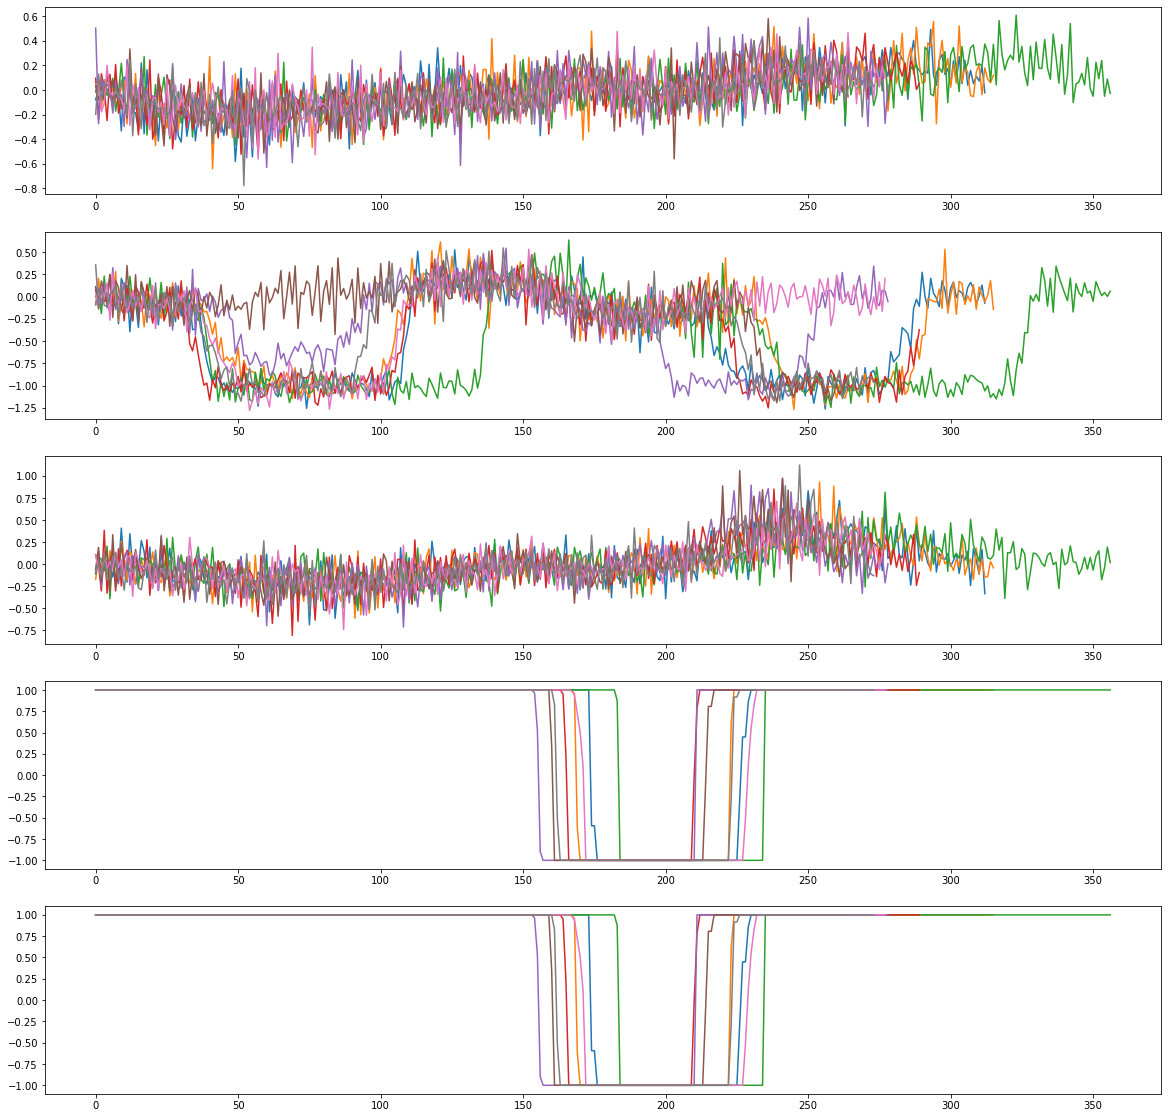

In [38]:
fig,  ax = plt.subplots(5, figsize=(20, 20))
for p in path_lists[1][0]:
    for i in range(5):  
        ax[i].plot(p['actions'][:, i])
plt.show()